## Example 00 - Basic simulation
In this notebook, we are going to make a simulation which forces a vessel to move over a certain 1D waterway network. It tries to give one an understanding of the most basic core functions of OpenTNSim and teach one the requirements to set-up a basic OpenTNSim model run. 

### Imports
Import the required libraries

In [2]:
# package(s) related to time, space and id
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx   

### Create graph
We first need to create a 1D network (a graph) along which the vessel will move. A graph contains edges (blue dots in plot below) and vertices (black lines in plot below). For this example, we will construct a network consisting of 4 nodes in a straight line. Since we would like to have two-way traffic, we add two edges between each pair of nodes: one from left to right, and another the other way around (however, we could easily apply one-way traffic as well by remove one of the two edges). Consequently, we arrive at a total of 4 nodes, and 6 edges.

Due to the nature of discrete modelling in which the time step is dependent on the activities (in this example: forcing a ship to move from node to node from its origin to its destination), it is important to add OpenTNSim mix-ins to the nodes in such a way we could identify the node (mix-in Identifiable, which imports a name and imports/creates an ID), and to locate the node (mix-in Locatable, which gives the node a geometry).

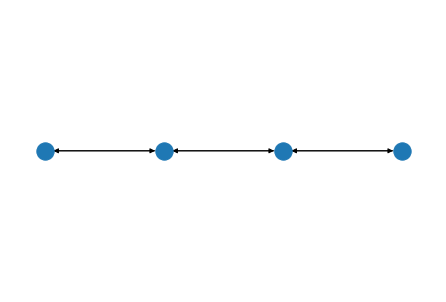

In [3]:
FG = nx.DiGraph()
nodes = []
path = []

Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

data_node_1 = {"name": "Node 1",
               "geometry": shapely.geometry.Point(0, 0)}
data_node_2 = {"name": "Node 2",
               "geometry": shapely.geometry.Point(0.1, 0)}
data_node_3 = {"name": "Node 3",
               "geometry": shapely.geometry.Point(0.2, 0)}
data_node_4 = {"name": "Node 4",
               "geometry": shapely.geometry.Point(0.3, 0)}

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)
node_3 = Node(**data_node_3)
node_4 = Node(**data_node_4)

nodes = [node_1, node_2, node_3, node_4]

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

path = [[node_1, node_2], # From node 1 to node 2
        [node_2, node_3], # From node 2 to node 3
        [node_3, node_4], # From node 3 to node 4
        [node_4, node_3], # From node 4 to node 3
        [node_3, node_2], # From node 3 to node 2
        [node_2, node_1]] # From node 2 to node 1

for edge in path:
    FG.add_edge(edge[0].name, edge[1].name, weight = 1)

# env.FG = FG
nx.draw(FG, positions)
plt.show()

### Create vessel - add VesselProperties and ConsumesEnergy mixins
The following mix-ins are required for each vessel in our problem: Identifiable (gives the vessel a name and a random ID), Movable (gives that the object (*vessel*) can move with a fixed speed and logs this activity, it requires input for the following mix-ins: Locatable, Routeable, and Log), and Routable (gives the object a route). We now modify our original vessel from the basic example and include vessel properties (like width, length, etc.) and a mixin that is needed to calculate resistance and energy consumption.  

In [13]:
# Make your preferred class out of available mix-ins.
TransportResource = type('Vessel', 
                         (opentnsim.core.Identifiable, 
                          opentnsim.core.Movable, 
                          opentnsim.core.Routeable,
                          opentnsim.core.VesselProperties,     # needed to add vessel properties
                          opentnsim.core.HasContainer,         # needed to calculate filling degree
                          opentnsim.core.ConsumesEnergy), {})  # needed to calculate resistances            

In [22]:
# Create a dict with all important settings
data_vessel = {"env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": 4,
               "type": 'Dortmund-Eems (L <= 74 m)', 
               "B": 8.2, 
               "L": 67.0,
               "capacity": 1000,
               "level": 1000,
               "H_e": 2.0, 
               "H_f": 6.6, 
               "T_e": 1.5, 
               "T_f": 2.7, 
               "P_installed": 435.0, 
               "L_w": 1.0, 
               "C_b": 0.85
              }               

vessel = TransportResource(**data_vessel)

The construction year of the engine is 2011


### Define paths
We are going to create a simulation in which a vessel moves from *Node 1* to *Node 4*. Therefore, we need to create a vessel to which we will need to append this paths. Therefore, first let's create the path.

In [23]:
path = nx.dijkstra_path(FG, node_1.name, node_4.name)

### Run simulation
Now we can define the run. First, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the above route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

In [24]:
# Start simpy environment
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())

# Add graph to environment
env.FG = FG

# Add environment and path to the vessel
vessel.env = env                                        #the created environment
vessel.name = 'Vessel No.1'                     
vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)

# Start the simulation
env.process(vessel.move())
env.run()

### Output
We can now analyse the output of the simulation, which consists of the log-file of the vessel. We got this log-file as we added the log mix-in of OpenTNSim. This log-file keeps track of the moving activities of the vessel, and at which time and location they occur. The log-file could also keep track of an additional value, such as waiting times, which are not included here in this simulation.

As you can see, the vessel moves from its origin (*Node 1*) to its destination (*Node 4*) by passing *Node 2* and *Node 3* respectively. The time is calculated by the greater circle distance between the nodes, divided by the speed of the vessel.

Using this log-file, we could for example plot a time-distance graph.

In [25]:
df = pd.DataFrame.from_dict(vessel.log)
df

,Message,Timestamp,Value,Geometry
0,Sailing from node Node 1 to node Node 2 start,2021-05-22 11:34:07.000000,0,POINT (0 0)
1,Sailing from node Node 1 to node Node 2 stop,2021-05-22 12:20:29.987270,0,POINT (0.1 0)
2,Sailing from node Node 2 to node Node 3 start,2021-05-22 12:20:29.987270,0,POINT (0.1 0)
3,Sailing from node Node 2 to node Node 3 stop,2021-05-22 13:06:52.974540,0,POINT (0.2 0)
4,Sailing from node Node 3 to node Node 4 start,2021-05-22 13:06:52.974540,0,POINT (0.2 0)
5,Sailing from node Node 3 to node Node 4 stop,2021-05-22 13:53:15.961810,0,POINT (0.3 0)


In [26]:
vessel.container.__dict__

{'_env': None,
 '_capacity': 1000,
 'put_queue': [],
 'get_queue': [],
 'put': <bound method ContainerPut of <simpy.resources.container.Container object at 0x00000264EB71B2E0>>,
 'get': <bound method ContainerGet of <simpy.resources.container.Container object at 0x00000264EB71B2E0>>,
 '_level': 1000}

In [27]:
# create an EnergyCalculation object (vessel is used to initialise)
energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)

In [28]:
# Todo:
# - probably we need to add some properties to the graph (like depth, widht or so to the edges)
# - some debugging is still needed. It looks like
energycalculation.calculate_energy_consumption()

delta_t: 2782.9873 s
distance: 11131.9491 m
velocity: 4.0000 m/s


AttributeError: 'Vessel' object has no attribute 'alpha_xx'